# Exercise 4, answers

In [1]:
def f_constrained(x):
    return x[0]**2+x[1]**2+x[0]+2*x[1], [], [x[0]+x[1]-1]

## Task 1
* max 2 points, 2 points if correct result is obtained, reductions for flaws

In [2]:
def alpha(x,f): # define penalty function
    (_,ieq,eq) = f(x)
    return sum([min([0,ieq_j])**2 for ieq_j in ieq])\
+sum([eq_k**2 for eq_k in eq])

def penalized_function(x,f,r): # combine objective and penalty functions
    return f(x)[0] + r*alpha(x,f)

#### Let us solve the penalized problem with penalty term growin in a loop

In [3]:
start = [0,0] # starting point

import numpy as np
from scipy.optimize import minimize
r = 1 # initialize penalty parameter
x_old = np.array([float('inf')]*2)
x_new = start
steps = []
while np.linalg.norm(x_new-x_old)>0.0001: # stopping rule where the difference in the variable space is monitored
    x_old = x_new
    res = minimize(lambda x:penalized_function(x,f_constrained,r),
               x_old,method='Nelder-Mead') # solve penalty problems by using Nelder Mead from scipy.optimize 
    x_new = np.array(res.x)
    steps.append(list(x_new))
#    r = r+1 # update penalty parameter; increase it with the penalty function
    r = 10*r 
print(x_new, r) # print final solution and the final value of r
print(len(steps)) # print number of steps

[0.74998148 0.25000583] 1000000
6


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# plot steps
def plot_2d_steps2(steps,start,interval):
    myvec = np.array([start]+steps).transpose()
    plt.plot(myvec[0,],myvec[1,],'rx')
    for label,x,y in zip([str(i) for i in range(len(steps)+1)],myvec[0,],myvec[1,]):
        plt.annotate(label,xy = (x, y))
    # plot constraint
    z = np.arange(interval[0],interval[1],0.1)
    l = len(z)
    con = [1.0-z[i] for i in range(l)]
    plt.plot(z,con,'b-')
    return plt

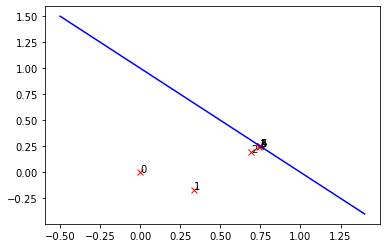

In [5]:
interval = [-0.5,1.5]
plot_2d_steps2(steps,start,interval).show()

## Task 2
* max 2 points, 2 points if correct result is obtained, reductions for flaws

In [6]:
# Give slack for the equality constraint and convert it into two inequality constraints.
# In this way, there are solutions inside the feasible region. Reduce slack when optimization progresses.
def f_constrained_approx(x,epsilon):
    return x[0]**2+x[1]**2+x[0]+2*x[1], [x[0]+x[1]-1+epsilon,\
                                         epsilon-(x[0]+x[1]-1)], []

In [7]:
# define barrier function
def beta(x,f):
    _,ieq,_ = f(x)
    try:
        value=sum([1/max([0,ieq_j]) for ieq_j in ieq])
    except ZeroDivisionError: # handle division by zero
        value = float("inf")
    return value

# combine the objective and barrier functions
def function_with_barrier(x,f,r):
    return f(x)[0]+r*beta(x,f)

In [8]:
start_b = [1,0] # feasible starting point

import numpy as np
import ad
from scipy.optimize import minimize

r = 1.0
epsilon = 0.1 # initial slack for constraints
x_old = np.array([float('inf')]*2)
x_new = start_b
steps_b = []
while np.linalg.norm(x_new-x_old)>0.0001:
    x_old = x_new
    g = lambda x: function_with_barrier(x,\
               lambda y: f_constrained_approx(y,epsilon),r)
#    res = minimize(g,x_old,method='Nelder-Mead')
    res = minimize(g,x_old,method='Newton-CG',jac=ad.gh(g)[0],\
                   hess=ad.gh(g)[1])
    x_new = res.x
    steps_b.append(list(x_new))
    r=r/2 # reduce penalty parameter
    epsilon = epsilon/2 # reduce slack
    print(x_new, f_constrained_approx(x_new,epsilon)[0], epsilon, r)

[0.7496876 0.2496876] 1.8734382075790998 0.05 0.5
[0.74992188 0.24992188] 1.8746094192446607 0.025 0.25
[0.74998047 0.24998047] 1.8749023465155652 0.0125 0.125


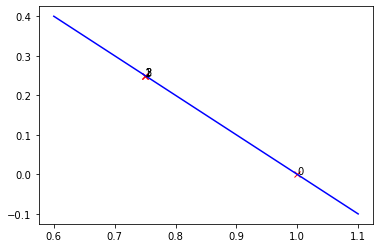

In [9]:
interval = [0.6,1.2]
plot_2d_steps2(steps_b,start_b,interval).show()

## Task 3
* max 2 points, 2 points if correct result is obtained, reductions for flaws

In [10]:
import numpy as np
def project_vector(A,vector):
    #convert A into a matrix
    A_matrix = np.matrix(A)
    #construct the "first row" of the matrix [[I,A^T],[A,0]]
    left_matrix_first_row = np.concatenate((np.identity(len(vector)),A_matrix.transpose()), axis=1)
    #construct the "second row" of the matrix
    left_matrix_second_row = np.concatenate((A_matrix,np.matrix(np.zeros([len(A),len(A)]))), axis=1)
    #combine the whole matrix by combining the rows
    left_matrix = np.concatenate((left_matrix_first_row,left_matrix_second_row),axis = 0)
    #Solve the system of linear equalities from the previous page
    return np.linalg.solve(left_matrix, \
                           np.concatenate((np.matrix(vector).transpose(),\
                                           np.zeros([len(A),1])),axis=0))[:len(vector)]         

In [11]:
import numpy as np
import ad
def projected_gradient_method(f,A,start,step,precision):
    f_old = float('Inf')
    x = np.array(start)
    steps_p = []
    f_new = f(x)
    while abs(f_old-f_new)>precision:
        f_old = f_new
        gradient = ad.gh(f)[0](x)
        grad_proj = project_vector(A,[-i for i in gradient])#The only changes to steepest..
        grad_proj = np.array(grad_proj.transpose())[0] #... descent are here!
        print(grad_proj)
        x = x+grad_proj*step
        f_new = f(x)
        steps_p.append(list(x))
    return x,f_new,steps_p

In [12]:
[x,f,s] = projected_gradient_method(lambda x:f_constrained(x)[0],[[1,1]],start_b\
                          ,.5,0.000001)
print(x)

[-0.5  0.5]
[0. 0.]
[0.75 0.25]


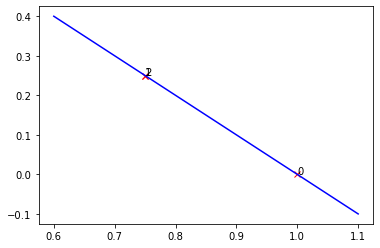

In [13]:
plot_2d_steps2(s,start_b,interval).show()

## Task 4
* max 2 points, 2 points if correct result is obtained, reductions for flaws

Need to show that there exists unique Lagrance multiplier vectors $\lambda^* = (\lambda^*_1,\ldots,\lambda_J^*)$ and $\mu^*=(\mu_1^*,\ldots,\mu_K^*)$ such that
$$
\begin{align}
&\nabla_xL(x,\mu,\lambda) = 0\\
&\mu_j^*\geq0,\text{ for all }j=1,\ldots,J\\
&\mu_j^*g_j(x)=0,\text{for all }j=1,\ldots,J,
\end{align}
$$
where $$L(x,\lambda,\mu) = f(x)- \sum_{k=1}^K\mu_kg_k(x) -\sum_{j=1}^J\lambda_jh_j(x)$$

Now,  $f(x) = x_1^2+x_2^2+x_1+2x_2$, $g(x) = 0$ and $h(x)=x_1+x_2-1$.

Thus, stationary rule becomes $$
\left\{
\begin{align}
2x_1+1-\lambda = 0\\
2x_2+2-\lambda=0.
\end{align}
\right.
$$


We do not have a complementary rule, since we do not have inequality constraints!

In [15]:
# Subroutine to check whether a given solution x satisfies the stationary rule with given tolerance.
# In the equations above, we have l = 2x1 + 1 = 2x2 + 2. Multiplier l can thus have any real value.
def check_KKT_eqc(x,tol):
    l = 2*x[0]+1 # first equation above
    print(2*x[1]+2-l)
    if abs(2*x[1]+2-l)<=tol:
        return True
    return False

In [16]:
check_KKT_eqc([1.0,0.0],0.000001)
check_KKT_eqc([0.8,0.2],0.000001)
check_KKT_eqc([0.74998093,0.24998093],0.000001)
check_KKT_eqc([0.75,0.25],0.000001)

-1.0
-0.20000000000000018
0.0
0.0


True